# **Final Project: Artificial Neural Network (CuPy vs NumPy)**

---
#### **Students:** Yomna Youssef, Nataliia Solodovnikova, MSc-2, Space and Engineering Systems
#### **Course:** High Performance Python Lab
#### Skoltech 2021
---


The goal of our project is to implement artificial neural networks (ANNs) layers using NumPy and CuPy and compare the computational performance of both implementations. We perform several experiments on the Digit Classification MNIST and measure the speedup against network parameters.


## Imports

In [ ]:
## imports ##
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm.auto import tqdm
from layers_cp import *
from layers_np import *

## Digit classification task

Now, we are developing the digit classification ANN. The goal is to correctly classify digits from handwritten images. The MNIST dataset is used for training.
Each number is represented as a 3D matrix. Then, flatten it to 1D and train a fully connected layered model.



### Model development

In [ ]:
# batch generator
def cp_get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = cp.arange(n_samples)
    cp.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

def cp_train(model, input_train, output_train, n_epoch, batch_size, criterion, opt, opt_config):
  optimizer_state = {}  
  loss_history = []
  
  for i in range(n_epoch):
    for x_batch, y_batch in cp_get_batches((input_train, output_train), batch_size):
      
        # zero out gradient of parameters
        for layer in model:
          layer.zeroGradParameters()

        #forward pass
        y = []
        y.append(x_batch)
        for layer in model:
          output = layer.forward(y[-1])
          y.append(output)

        pred = output
        loss = criterion.forward(pred, y_batch)

        # Backward pass
        dp = criterion.backward(pred, y_batch)
        gradInput = dp
        for n in range(len(model), 0, -1):
          gradInput = model[n-1].backward(y[n-1], gradInput)
        
        #create list of lists for parameters
        param_list = []
        param_grad_list= []
        for layer in model:
          param_list.append(layer.getParameters())
          param_grad_list.append(layer.getGradParameters())
        
        if opt == 'adam':
          # Update weights
          cp_adam_optimizer(param_list, param_grad_list, opt_config, optimizer_state)
        else:
          cp_sgd_momentum(param_list, param_grad_list, opt_config, optimizer_state)      
        
        loss_history.append(loss)
  return loss_history  

In [ ]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

def train(model, input_train, output_train, n_epoch, batch_size, criterion, opt, opt_config):
  optimizer_state = {}  
  loss_history = []
  
  for i in range(n_epoch):
    for x_batch, y_batch in get_batches((input_train, output_train), batch_size):
      
        # zero out gradient of parameters
        for layer in model:
          layer.zeroGradParameters()

        #forward pass
        y = []
        y.append(x_batch)
        for layer in model:
          output = layer.forward(y[-1])
          y.append(output)

        pred = output
        loss = criterion.forward(pred, y_batch)

        # Backward pass
        dp = criterion.backward(pred, y_batch)
        gradInput = dp
        for n in range(len(model), 0, -1):
          gradInput = model[n-1].backward(y[n-1], gradInput)
        
        #create list of lists for parameters
        param_list = []
        param_grad_list= []
        for layer in model:
          param_list.append(layer.getParameters())
          param_grad_list.append(layer.getGradParameters())
        
        if opt == 'adam':
          # Update weights
          adam_optimizer(param_list, param_grad_list, opt_config, optimizer_state)
        else:
          sgd_momentum(param_list, param_grad_list, opt_config, optimizer_state)      
        
        loss_history.append(loss)
  return loss_history        

### Data load

In [ ]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# convert to cupy array
x_train_gpu = cp.asarray(x_train)
y_train_gpu = cp.asarray(y_train)
x_test_gpu = cp.asarray(x_test)
y_test_gpu = cp.asarray(y_test)

#One-hot encode the labels first.
y_train_hot = np.eye(10)[y_train]
y_test_hot  = np.eye(10)[y_test]

#One-hot encode the labels first.
y_train_hot_gpu = cp.eye(10)[y_train_gpu]
y_test_hot_gpu  = cp.eye(10)[y_test_gpu]

#reshape our 2D data to 1D.
x_train_gpu = x_train_gpu.reshape(x_train_gpu.shape[0], -1)
x_test_gpu = x_test_gpu.reshape(x_test_gpu.shape[0], -1)

#reshape our 2D data to 1D.
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

11501568/11490434 [==============================] - 0s 0us/step


## Experiments

In this section we compare the CuPy and NumPy implemetations.

### Experiment A. Base experiment

First of all, we compare the performance of the original model characteristics implemented using NumPy and CuPy.

#### NumPy implementation

In [ ]:
#Initialize model
model_base_np = []
# define layers
l1 = Linear(x_train.shape[1], 128)
f1 = ReLU()
l2 = Linear(128, 64)
f2 = ReLU()
l3 = Linear(64, y_train_hot.shape[1])
sm = LogSoftMax()
# add layers to model
model_base_np = [l1, f1, l2, f2, l3, sm]
# Define Criterion
criterion = ClassNLLCriterion()
# Optimizer params
optimizer_config = {'learning_rate':0.001, 'beta1':0.9, 'beta2':0.999, 'epsilon':1e-8}

In [ ]:
loss_1 = train(model_base_np, x_train, y_train_hot, 20, 256, criterion, opt='adam', opt_config=optimizer_config)

In [ ]:
%%timeit -n 5 -r 1
loss_1 = train(model_base_np, x_train, y_train_hot, 20, 256, criterion, opt='adam', opt_config=optimizer_config)

5 loops, best of 1: 58.6 s per loop


#### CuPy implementation

In [ ]:
#Initialize model
model_base_cp = []
# define layers
l1 = cp_Linear(x_train.shape[1], 128)
f1 = cp_ReLU()
l2 = cp_Linear(128, 64)
f2 = cp_ReLU()
l3 = cp_Linear(64, y_train_hot.shape[1])
sm = cp_LogSoftMax()
# add layers to model
model_base_cp = [l1, f1, l2, f2, l3, sm]
# Define Criterion
cp_criterion = cp_ClassNLLCriterion()
# Optimizer params
optimizer_config = {'learning_rate':0.001, 'beta1':0.9, 'beta2':0.999, 'epsilon':1e-8}

In [ ]:
loss_cp = cp_train(model_base_cp, x_train_gpu, y_train_hot_gpu, 20, 256, cp_criterion, opt='adam', opt_config=optimizer_config)

In [ ]:
%%timeit -n 5 -r 1
loss_cp = cp_train(model_base_cp, x_train_gpu, y_train_hot_gpu, 20, 256, criterion, opt='adam', opt_config=optimizer_config)

5 loops, best of 1: 35.8 s per loop


#### Plot loss vs epochs

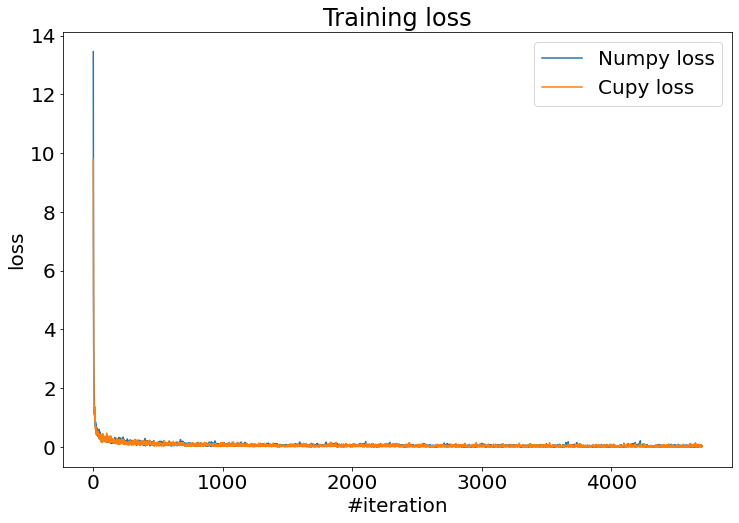

In [ ]:
#plot losses of the models vs #iterations
plt.figure(figsize=(12, 8))     
plt.rcParams.update({'font.size': 20})
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_1)
plt.plot(loss_cp)
plt.legend(['Numpy loss', 'Cupy loss'])
plt.show()

#### Sample of result

prediction:  6
Target:  6


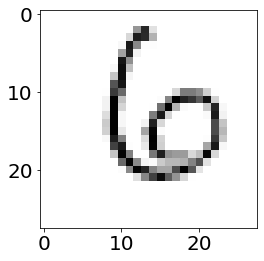

In [ ]:
img = x_test_gpu[100:101].reshape(28,28)
pred = x_test_gpu[100:101]
for layer in model_base_cp:
  pred = layer.forward(pred)
print("prediction: ", cp.argmax(pred[0]))
print("Target: ", y_test[100])
plt.imshow(cp.asnumpy(img), cmap='Greys')

$\large \boxed{\text{The speed up of the base experiment is } 1.628}$

### Experiment B. Speedup vs. number of epochs

For epochs in a range from 5 to 25 we compare both implementations and see that the higher the number the bigger speedup we get.

#### NumPy implementation

In [ ]:
times_B = []
for epochs in tqdm(range(5, 30, 5)):
    time = %timeit -o -q train(model_base_np, x_train, y_train_hot, epochs, 256, criterion, opt='adam', opt_config=optimizer_config)
    times_B.append(time)

#### CuPy implementation

In [ ]:
cp_times_B = []
for epochs in tqdm(range(5, 30, 5)):
    time = %timeit -o -q cp_train(model_base_cp, x_train_gpu, y_train_hot_gpu, epochs, 256, cp_criterion, opt='adam', opt_config=optimizer_config)
    cp_times_B.append(time)

  0%|          | 0/5 [00:00<?, ?it/s]

#### Speedup

In [ ]:
speedup_B = [times_B[t].best / cp_times_B[t].best  for t in range(len(times_B))]

#### Plot speedup vs. number of epochs

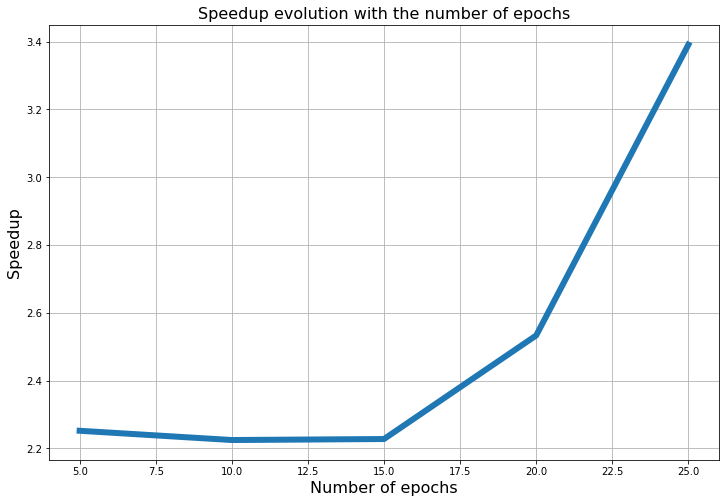

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Speedup evolution with the number of epochs', fontsize=16)
plt.plot(np.arange(5, 30, 5), speedup_B, linewidth=6)
plt.xlabel('Number of epochs', fontsize=16)
plt.ylabel('Speedup', fontsize=16)
plt.grid()
plt.show()

### Experiment C. Speedup vs. batch size

We also estimate the speedu for for batch sizes of 64, 128, 256, 512 and 1024.

**Note:** Instead of running the train for different batch sizes in a single `for` loop like in the previous experiment, we run each case separately and collect the outputs. The reason we do it is the `%timeit` gliches, it seemed to be unable to safe the results in one array even when operating with two options of batch sizes.

#### NumPy implementation

In [ ]:
# times_С = []
# for batch_sizes in tqdm([64, 128, 256, 512, 1024]):
#     time = %timeit -o -q train(model_base_np, x_train, y_train_hot, 20, batch_sizes, criterion, opt='adam', opt_config=optimizer_config)
#     times_C.append(time)

In [ ]:
%timeit -o -r 1 train(model_base_np, x_train, y_train_hot, 20, 64, criterion, opt='adam', opt_config=optimizer_config)

1 loop, best of 1: 1min 59s per loop


<TimeitResult : 1 loop, best of 1: 1min 59s per loop>

In [ ]:
%timeit -o -r 1 train(model_base_np, x_train, y_train_hot, 20, 128, criterion, opt='adam', opt_config=optimizer_config)

1 loop, best of 1: 1min 21s per loop


<TimeitResult : 1 loop, best of 1: 1min 21s per loop>

In [ ]:
%timeit -o -r 1 train(model_base_np, x_train, y_train_hot, 20, 256, criterion, opt='adam', opt_config=optimizer_config)

1 loop, best of 1: 1min 1s per loop


<TimeitResult : 1 loop, best of 1: 1min 1s per loop>

In [ ]:
%timeit -o -r 1 train(model_base_np, x_train, y_train_hot, 20, 512, criterion, opt='adam', opt_config=optimizer_config)

1 loop, best of 1: 56 s per loop


<TimeitResult : 1 loop, best of 1: 56 s per loop>

In [ ]:
%timeit -o -r 1 train(model_base_np, x_train, y_train_hot, 20, 1024, criterion, opt='adam', opt_config=optimizer_config)

1 loop, best of 1: 54.4 s per loop


<TimeitResult : 1 loop, best of 1: 54.4 s per loop>

#### CuPy implementation

In [ ]:
# cp_times_С = []
# for batch_sizes in tqdm([64, 128, 256, 512, 1024]):
#     time = %timeit -o -q cp_train(model_base_cp, x_train_gpu, y_train_hot_gpu, 20, batch_sizes, cp_criterion, opt='adam', opt_config=optimizer_config)
#     cp_times_C.append(time)

In [ ]:
%timeit -o -r 1 cp_train(model_base_cp, x_train_gpu, y_train_hot_gpu, 20, 64, cp_criterion, opt='adam', opt_config=optimizer_config)

1 loop, best of 1: 1min 50s per loop


<TimeitResult : 1 loop, best of 1: 1min 50s per loop>

In [ ]:
%timeit -o -r 1 cp_train(model_base_cp, x_train_gpu, y_train_hot_gpu, 20, 128, cp_criterion, opt='adam', opt_config=optimizer_config)

1 loop, best of 1: 53.6 s per loop


<TimeitResult : 1 loop, best of 1: 53.6 s per loop>

In [ ]:
%timeit -o -r 1 cp_train(model_base_cp, x_train_gpu, y_train_hot_gpu, 20, 256, cp_criterion, opt='adam', opt_config=optimizer_config)

1 loop, best of 1: 26.9 s per loop


<TimeitResult : 1 loop, best of 1: 26.9 s per loop>

In [ ]:
%timeit -o -r 1 cp_train(model_base_cp, x_train_gpu, y_train_hot_gpu, 20, 512, cp_criterion, opt='adam', opt_config=optimizer_config)

1 loop, best of 1: 12.7 s per loop


<TimeitResult : 1 loop, best of 1: 12.7 s per loop>

In [ ]:
%timeit -o -r 1 cp_train(model_base_cp, x_train_gpu, y_train_hot_gpu, 20, 1024, cp_criterion, opt='adam', opt_config=optimizer_config)

1 loop, best of 1: 6.38 s per loop


<TimeitResult : 1 loop, best of 1: 6.38 s per loop>

#### Speedup

In [ ]:
times_С = [119, 81, 61, 56, 54.4]
cp_times_С = [110, 53.6, 26.9, 12.7, 6.38]

speedup_C = [times_С[t] / cp_times_С[t]  for t in range(len(times_С))]

#### Plot speedup vs. batch size

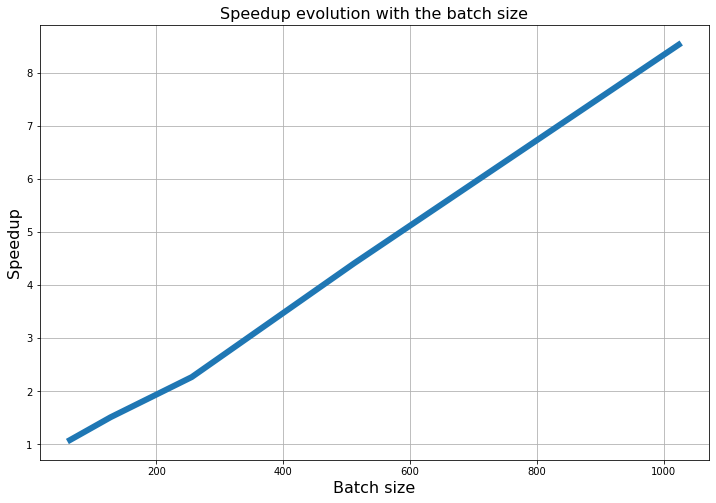

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Speedup evolution with the batch size', fontsize=16)
plt.plot([64, 128, 256, 512, 1024], speedup_C, linewidth=6)
plt.xlabel('Batch size', fontsize=16)
plt.ylabel('Speedup', fontsize=16)
plt.grid()
plt.show()

## Experiment D speed up of Wide network vs Deep network

### Numpy

In [ ]:
# define layers
l1 = Linear(x_train.shape[1], 128)
f1 = ReLU()
l2 = Linear(128, 128)
f2 = ReLU()
l3 = Linear(128, 64)
f3 = ReLU()
l4 = Linear(64, 64)
f4 = ReLU()
l5 = Linear(64, y_train_hot.shape[1])
sm = LogSoftMax()
# add layers to model
model_deeper_np = [l1, f1, l2, f2, l3, f3, l4, f4, l5, sm]

In [ ]:
%%timeit -n 5 -r 1
loss_cp = train(model_deeper_np, x_train, y_train_hot, 20, 256, criterion, opt='adam', opt_config=optimizer_config)

5 loops, best of 1: 1min 16s per loop


In [ ]:
# define layers
l1 = Linear(x_train.shape[1], 128)
f1 = ReLU()
l2 = Linear(128, 213)
f2 = ReLU()
l3 = Linear(213, y_train_hot.shape[1])
sm = LogSoftMax()
# add layers to model
model_wider_np = [l1, f1, l2, f2, l3, sm]

In [ ]:
%%timeit -n 5 -r 1
loss_cp = train(model_wider_np, x_train, y_train_hot, 20, 256, criterion, opt='adam', opt_config=optimizer_config)

5 loops, best of 1: 1min 14s per loop


### CuPy

In [ ]:
# define layers
l1 = cp_Linear(x_train.shape[1], 128)
f1 = cp_ReLU()
l2 = cp_Linear(128, 128)
f2 = cp_ReLU()
l3 = cp_Linear(128, 64)
f3 = cp_ReLU()
l4 = cp_Linear(64, 64)
f4 = cp_ReLU()
l5 = cp_Linear(64, y_train_hot.shape[1])
sm = cp_LogSoftMax()
# add layers to model
model_deeper_cp = [l1, f1, l2, f2, l3, f3, l4, f4, l5, sm]

In [ ]:
%%timeit -n 5 -r 1
loss_cp = train(model_deeper_cp, x_train_gpu, y_train_hot_gpu, 20, 256, cp_criterion, opt='adam', opt_config=optimizer_config)

5 loops, best of 1: 51.9 s per loop


In [ ]:
# define layers
l1 = cp_Linear(x_train.shape[1], 128)
f1 = cp_ReLU()
l2 = cp_Linear(128, 213)
f2 = cp_ReLU()
l3 = cp_Linear(213, y_train_hot.shape[1])
sm = cp_LogSoftMax()
# add layers to model
model_wider_cp = [l1, f1, l2, f2, l3, sm]

In [ ]:
%%timeit -n 5 -r 1
loss_cp = train(model_wider_cp, x_train_gpu, y_train_hot_gpu, 20, 256, cp_criterion, opt='adam', opt_config=optimizer_config)

5 loops, best of 1: 33 s per loop


In [ ]:
print("increase in speed up: ", ((2.242424242424242-1.46435452793834)/1.46435452793834) * 100)

increase in speed up:  53.13397129186631
